#  Classifier in Pytorch By Anubhav Natani 

In this notebook insted of writing full codes i had made functions for train,test,fit,infrence those are necessary as to keep the code modular as well they are really helpfull when we debug the code i would suggest everyone to follow the same

> Torchvision module contain several boiler plate code for data prepossing and also contains the datasetsm

In [1]:
import torch
import torchvision 
import torchvision.transforms as transforms

> Transforms are used for image transformation

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

> Downloading the dataset
1. Making the loader of the dataset
2. Applying the transforms

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [4]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [5]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False,num_workers=2)

> loader has dataset so loder gives data in the batches

> Plotting the train and test samples

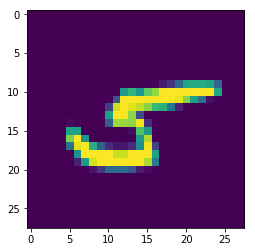

5


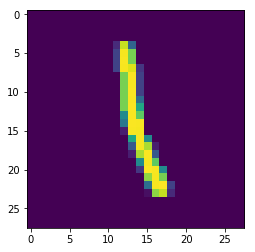

1


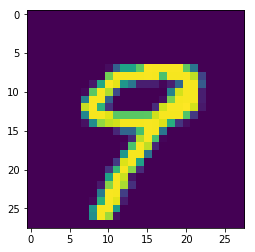

9


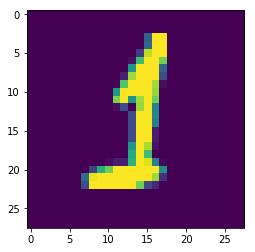

1


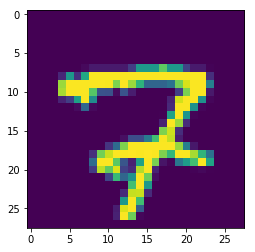

7


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    #unnormalize
    img = img*0.3081+0.1307
    a = img.numpy()
    #bringing first two shape values at first
    a = a.reshape(a.shape[1],a.shape[2])
    plt.imshow(a)
    plt.show()
    
dataiter = iter(trainloader)
images,labels = dataiter.next()

for i in range(0,5):
    imshow(images[i])
    print(labels[i].item())
#imshow(images[0])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

> Defining a conv netwrok for the task

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dense1 = nn.Linear(64*12*12,128)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(128,10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(-1,64*12*12)
        x = F.relu(self.dense1(x))
        x = self.dropout2(x)
        x = self.dense2(x)
        return x
    
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25)
  (dense1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5)
  (dense2): Linear(in_features=128, out_features=10, bias=True)
)


> Defining a loss function and optimizer

In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

>Writing the functions for training and testing the pytorch models and a utility function like keras for fitting the modelm

In [11]:
# training model in pytorch
def train(model, device, train_loader, optimizer, criterion, epoch, train_losses):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward(retain_graph=True)
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    #calculating the total loss
    train_loss = ((train_loss)/len(train_loader.dataset))
    train_losses.append(train_loss)
    #logging the result
    print("Train Epoch: %d Train Loss: %.4f." % (epoch, train_loss))

    
# testing model in pytorch
def test(model, device, test_loader, criterion, epoch, test_losses, accuracies):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    #test loss calculation
    test_loss = (test_loss/len(test_loader.dataset))
    #calculating the accuracy in the validation step
    accuracy = (100*correct)/len(test_loader.dataset)
    accuracies.append(accuracy)
    test_losses.append(test_loss)
    #logging the results
    print("Test Epoch: %d Test Loss: %.4f Test Accuray: %.2f." %
          (epoch, test_loss, accuracy))


# model fitting in pytorch
def fit(model, device, train_loader, test_loader, optimizer, criterion, no_of_epochs):
    train_losses = []
    test_losses = []
    accuracies = []
    for epoch in range(0, no_of_epochs):
        train(model, device, train_loader, optimizer,
              criterion, epoch, train_losses)
        test(model, device, test_loader, criterion,
             epoch, test_losses, accuracies)
    return train_losses, test_losses, accuracies

>Training the neural network

In [12]:
train_losses,test_losses,accuracies = fit(net,device,trainloader,testloader,optimizer,criterion,10)

Train Epoch: 0 Train Loss: 0.2441.
Test Epoch: 0 Test Loss: 0.0004 Test Accuray: 98.33.
Train Epoch: 1 Train Loss: 0.0963.
Test Epoch: 1 Test Loss: 0.0003 Test Accuray: 98.75.
Train Epoch: 2 Train Loss: 0.0714.
Test Epoch: 2 Test Loss: 0.0003 Test Accuray: 98.83.
Train Epoch: 3 Train Loss: 0.0618.
Test Epoch: 3 Test Loss: 0.0002 Test Accuray: 99.01.
Train Epoch: 4 Train Loss: 0.0562.
Test Epoch: 4 Test Loss: 0.0003 Test Accuray: 99.01.
Train Epoch: 5 Train Loss: 0.0493.
Test Epoch: 5 Test Loss: 0.0002 Test Accuray: 99.05.
Train Epoch: 6 Train Loss: 0.0404.
Test Epoch: 6 Test Loss: 0.0002 Test Accuray: 99.21.
Train Epoch: 7 Train Loss: 0.0378.
Test Epoch: 7 Test Loss: 0.0002 Test Accuray: 99.20.
Train Epoch: 8 Train Loss: 0.0325.
Test Epoch: 8 Test Loss: 0.0002 Test Accuray: 99.17.
Train Epoch: 9 Train Loss: 0.0321.
Test Epoch: 9 Test Loss: 0.0002 Test Accuray: 99.16.


> After training and testing the models we can save the model

In [13]:
torch.save(net.state_dict(),"mnist_cnn.pt")

> Plotting the losses

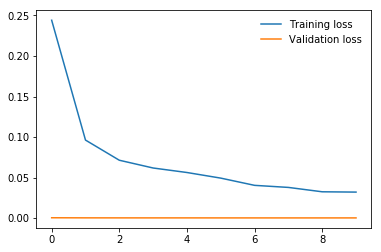

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Text(0.5, 0, 'Epocs')

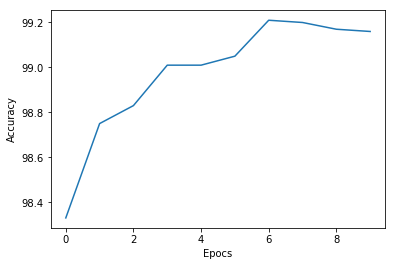

In [15]:
plt.plot(accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Epocs")

> Using model for infrence

In [16]:
state_dict = torch.load('mnist_cnn.pt')
print(state_dict.keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'dense1.weight', 'dense1.bias', 'dense2.weight', 'dense2.bias'])


> We can save model with state dict for no furthur problem as loading only the state dict requires the model too

checkpoint = {
    'input_size':(1,28,28),
    'output_size':10,
    'hidden_layers':[each.out_features for each in net.layers],
    'state_dict':net.state_dict()}
torch.save(checkpoint,'checkpoint.pth')

In [17]:
net.load_state_dict(state_dict)

In [18]:
type(net)

__main__.Net

In [19]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

In [20]:
def infrence(model,data,label):
    model.eval()
    model.to("cpu")
    with torch.no_grad():
        output = model(data)
    ps = torch.argmax(torch.nn.functional.softmax((output),dim=1))
    
    print("Actual Label: "+ str(label.item())+" Predicted Label: "+str(ps.item()))

In [21]:
infrence(net,images[1].reshape(1,1,28,28),labels[1])

Actual Label: 9 Predicted Label: 9
